# Finding the areas suitable for planning future development in Jaipur City

<p style='text-align: justify;'>Jaipur is the capital city of Indian state of Rajasthan,which has been growing at a tremendous rate from the last 5-10 years. It is one of many metropolitan cities in making and identifying investment areas in property development could work wonders for developers. Thus, our aim is to find those areas in Jaipur City which are underdeveloped.</p>

<p style='text-align: justify;'><strong>Goal</strong> - Finding the property development oppurtunities in Jaipur City</p>

<p style='text-align: justify;'><strong>Analytical Method</strong> - We will use K means clustering algorithm to cluster the neighborhoods, based on the number of venues of top 10 categories of business in each neighborhood.</p>

__Methodology__ -  
Step 1 - Web Scrapping the data and transform it into a pandas dataframe  
Step 2 - Get the geographical coordinates of the neighborhood  
Step 3 - Connecting with FourSquare API and creating new dataframe that contain categories and number of venues of each category for each neighborhood  
Step 4 - Exploring and Clustering the neighborhoods using K-Means algorithm  
Step 5 - Select the best cluster for your goal

## 1. Web Scrapping the data and transforming it into a dataframe

Lets first import the required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install geocoder
import geocoder # to get coordinates

from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound

import requests # library to handle requests
!pip install beautifulsoup4
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

     |████████████████████████████████| 122kB 6.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 11.3MB/s ta 0:00:01
     |████████████████████████████████| 92kB 16.8MB/s eta 0:00:01
     |████████████████████████████████| 829kB 24.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 122kB 5.3MB/s eta 0:00:01
Libraries imported.


Now that all the libraries have been imported, next step is to look for the online source to scrap the data. After thorough web browsing, we find the requisite data on __'Maps of India'__ site.

In [2]:
import urllib.request
url = "https://www.mapsofindia.com/pincode/india/rajasthan/jaipur/"
url

'https://www.mapsofindia.com/pincode/india/rajasthan/jaipur/'

After storing the site location in a variable, we open this url by sending request through urllib. This process stores the data in html format inside Jaipur_neigh variable. Once we have the page, we will use Beautiful Soup library to parse through the page.

In [3]:
Jaipur_neigh = urllib.request.urlopen(url)
Jaipursoup = BeautifulSoup(Jaipur_neigh)
Neigh_table=Jaipursoup.find('table') # There is only one table on the web page and it does not have class name
# Neigh_table

After finding the required data inside this table, we parse through it and store the data in lists.

In [4]:
#Generate lists
A=[]
B=[]
for row in Neigh_table.findAll("tr"):
    cells = row.findAll('td')
    if len(cells)==4:
        A.append(cells[0].find(text=True)) #Only extract the neighbourhood and pin code
        B.append(cells[1].find(text=True))

Next, we create a new dataframe and add these lists as columns to the dataframe.

In [5]:
df_neigh=pd.DataFrame(A,columns=['Location'])
df_neigh['Pin Code']=B
df_neigh.head()

,Location,Pin Code
0,Location,Pincode
1,A C jobner,303329
2,A.G.office,302005
3,Ashoknagar,302001
4,Achalpura,303908


In [6]:
#dropping the first row containing table heading
df_neigh = df_neigh.drop(0)
df_neigh = df_neigh.reset_index(drop=True)
df_neigh.head()

,Location,Pin Code
0,A C jobner,303329
1,A.G.office,302005
2,Ashoknagar,302001
3,Achalpura,303908
4,Achrol,303002


In [7]:
print("The number of neighborhoods in Jaipur are ",df_neigh.shape)

The number of neighborhoods in Jaipur are  (562, 2)


Although the data is retrieved, the uniqueness of the data is not known. Let's check how many neighborhoods fall under the same pincode.

In [8]:
# print(df_neigh['Pin Code'].value_counts())
# print(df_neigh['Location'].value_counts())

#Finding the unique Neighborhoods
print("The unique pin codes are ",df_neigh['Pin Code'].nunique())

The unique pin codes are  77


Let's  group data by Pin Codes to generate unique rows. In the process, we will group different Neighborhoods under same Pin Code using delimiter ','

In [9]:
df_jaipur = df_neigh.groupby('Pin Code', as_index=False).agg(','.join)
df_jaipur.head()

,Pin Code,Location
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,..."
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj..."
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand..."
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag..."
4,302005,"A.G.office,High Court,Legislative Assembly,N.C..."


In [10]:
print("The number of unique neighborhoods after grouping are ",df_jaipur.shape)

The number of unique neighborhoods after grouping are  (77, 2)


In [11]:
#saving the data for future use
df_neigh.to_csv('Jaipur_Pincode.csv',index=False)
df_jaipur.to_csv('Neighborhood_Jaipur.csv',index=False)

## 2. Now that we have Neighborhood data with us, Let's find the geographical coordinates for all locations.

In [12]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Jaipur, Rajasthan'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [13]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df_jaipur["Pin Code"].tolist() ]

In [14]:
print("The length of corrdinates data retrieved is ",len(coords))

The length of corrdinates data retrieved is  77


In [15]:
coords[0:6]

[[26.930038198008976, 75.80509179210249],
 [26.942590714000062, 75.83860000000004],
 [26.91063500000007, 75.84966227600006],
 [26.887956048000035, 75.83186000000006],
 [26.89951074700008, 75.79193500000008],
 [26.91469472400007, 75.77727000000004]]

In [16]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [17]:
# merge the coordinates into the original dataframe
df_jaipur['Latitude'] = df_coords['Latitude']
df_jaipur['Longitude'] = df_coords['Longitude']

In [18]:
print(df_jaipur.shape)
df_jaipur.head()

(77, 4)


,Pin Code,Location,Latitude,Longitude
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935


Let's save this file also

In [19]:
df_jaipur.to_csv('Jaipur_Final_DataFrame.csv',index=False)

Let's first create a map of jaipur with neighbourhoods superimposed on top.

In [20]:
address = 'Jaipur, Rajasthan'

geolocator = Nominatim(user_agent="Jaipur_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Jaipur City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Jaipur City are 26.916194, 75.820349.


In [21]:
# create map of Jaipur using latitude and longitude values
#from IPython.display import display
map_jaipur = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, pin_code,neighborhood in zip(df_jaipur['Latitude'], df_jaipur['Longitude'],df_jaipur['Pin Code'], df_jaipur['Location']):
    label = '{}, {}'.format(neighborhood, pin_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jaipur)  
    
map_jaipur

In [22]:
# save the map as HTML file
map_jaipur.save('map_jaipurdistrict.html')

Analyzing this map, we realize that this data covers whole Jaipur District. But we want to do analysis for only the main Jaipur City. After careful examination of the graph and based on our prior knowledge of the city's geography, we have identified that the Pin Codes starting with '303***', and thereafter, are outside the main city and therefore our analysis.

#### We will now fetch the data only for the main Jaipur City.

In [23]:
#Finding the data type of the columns
df_jaipur.dtypes

Pin Code      object
Location      object
Latitude     float64
Longitude    float64
dtype: object

In [24]:
#Convert the PinCode to integer for enabling removal of outside city PinCodes
df_jaipur['Pin Code'] = df_jaipur['Pin Code'].astype("int")
df_jaipur.dtypes

Pin Code       int64
Location      object
Latitude     float64
Longitude    float64
dtype: object

In [25]:
#Creating a new dataframe with locations inside the city
df_jaipurcity = df_jaipur[df_jaipur['Pin Code'] < 303000]
df_jaipurcity

,Pin Code,Location,Latitude,Longitude
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935
5,302006,"Ajmer Road,Industrial Estate,Jaipur R.s.,Khati...",26.914695,75.777270
6,302011,Airport Sanganer,26.925730,75.806590
7,302012,"Bindayaka,Dhankya,Jhotwara,Jhotwara Industrial...",26.960270,75.665821
8,302013,"Akhepura,Murlipura,Neendar,Road No-5 vkia,Vish...",27.044835,75.805821
9,302015,"Bajaj Nagar,Bapu Nagar,Barkat Nagar,Gandhi Nag...",26.890574,75.797725


In [26]:
# Find the neighborhoods in main Jaipur City
print("The number of Neighborhoods in main Jaipur city are", df_jaipurcity.shape)

The number of Neighborhoods in main Jaipur city are (26, 4)


Let's visualize the map once again with the city data

In [27]:
# create map of Jaipur using latitude and longitude values
#from IPython.display import display
map_jaipurcity = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, pin_code,neighborhood in zip(df_jaipurcity['Latitude'], df_jaipurcity['Longitude'],df_jaipurcity['Pin Code'], df_jaipurcity['Location']):
    label = '{}, {}'.format(neighborhood, pin_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jaipurcity)  
    
map_jaipurcity

In [28]:
# save the map as HTML file
map_jaipurcity.save('map_jaipurcity.html')

## 3. Connecting with FourSquare API and creating new dataframe that contains top 10 categories and number of venues of each category for each neighborhood

In [29]:
# @hidden_cell
CLIENT_ID = 'QC55UNQEURKO42J5VKMHWSVN0L2VR3LYC5SMWRHORGTGR04F' # your Foursquare ID
CLIENT_SECRET = 'S0U0AFLUUSY0XNWMIZXMTJPFEBM3NPV0LQ2L2W22AIWVFCC5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [30]:
#gwtting high level categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [31]:
len(results['response']['categories'])

10

In [32]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


In [33]:
#function for finding venue count for each cataegory for each neighborhood
def get_venues_count(lat,long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [34]:
#Create new dataframe to store venues data
df_venues = df_jaipurcity.copy()
for c in categories_list:
    df_venues[c[0]] = 0
    
df_venues.head()

,Pin Code,Location,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092,0,0,0,0,0,0,0,0,0,0
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600,0,0,0,0,0,0,0,0,0,0
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662,0,0,0,0,0,0,0,0,0,0
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860,0,0,0,0,0,0,0,0,0,0
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935,0,0,0,0,0,0,0,0,0,0


In [36]:
#Request number of venues, store result as CSV
for i, row in df_venues.iterrows():
    for c in categories_list:        
        df_venues.loc[i, c[0]] = get_venues_count(df_venues.Latitude.iloc[i], df_venues.Longitude.iloc[i], radius=1000, categoryId=c[1])
#     print(i)
    df_venues.to_csv('area_venues.csv')

In [62]:
df_venues=pd.read_csv('area_venues.csv', index_col=0)
df_venues.head()

,Pin Code,Location,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092,2,1,0,6,3,5,4,0,16,8
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600,1,0,0,11,0,1,8,0,9,9
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662,1,0,0,0,0,1,3,0,3,1
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860,2,5,2,6,5,6,6,3,2,8
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935,4,1,0,21,4,3,9,3,9,8


# 4. Explore and Cluster the Neighborhood data

In [38]:
#Normalizing the venue data
from sklearn.preprocessing import MinMaxScaler

X = df_venues.values[:,4:]
scaled_dataset = MinMaxScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
df_scaled = pd.DataFrame(scaled_dataset)
df_scaled.columns = [c[0] for c in categories_list]
df_scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.50,0.2,0.0,0.285714,0.6,0.833333,0.235294,0.00,0.80,0.666667
1,0.25,0.0,0.0,0.523810,0.0,0.166667,0.470588,0.00,0.45,0.750000
2,0.25,0.0,0.0,0.000000,0.0,0.166667,0.176471,0.00,0.15,0.083333
3,0.50,1.0,1.0,0.285714,1.0,1.000000,0.352941,0.75,0.10,0.666667
4,1.00,0.2,0.0,1.000000,0.8,0.500000,0.529412,0.75,0.45,0.666667


####  Visualize the normalized data for venues for each category using Box Plot

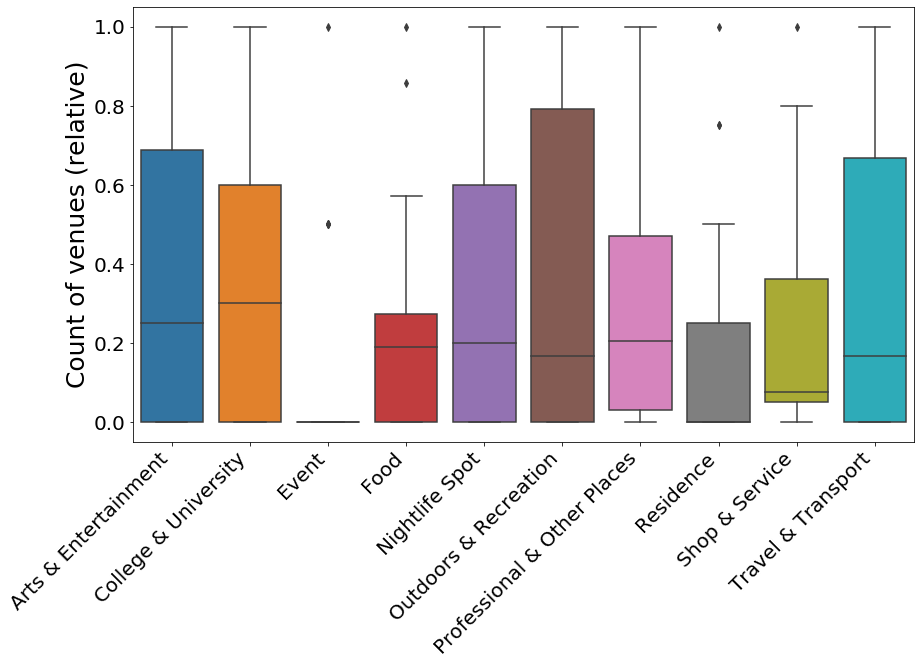

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

fig1 = plt.gcf()
plt.show()

In [47]:
#Save the box plot for future use
fig1.savefig("Category_Wise_Venues_Distribution_BoxPlot.png")

#### There's too little data for Event, so let's just drop that category.

In [63]:
df_venues.drop('Event', 1, inplace=True)
categories_list.remove(('Event', '4d4b7105d754a06373d81259'))

## Clustering

#### After running the preliminary analysis using kcluster value of 2, 3, and 4, we find that k value of 3 best segments the neighborhoods. In other K values, the outliers are higher when we visualize the resulting cluster using Box Plot.

#### Run K-means algorithm to cluster the Neighborrhood into 3 clusters denoting least developed, moderately developed and well developed areas.

In [56]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)

kmeans_labels = kmeans.labels_

df_venues_clustered = df_venues.copy()
df_venues_clustered['Cluster'] = kmeans_labels

#dataframe to be used for box plot
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

#### Visualize different Neighborhoods, now clustered, superimposed on Jaipur Map

In [59]:
map_jaipur1 = folium.Map(location=[latitude, longitude],zoom_start=10)

#add markers
for i, area, lat, long, cluster in zip(df_venues_clustered.index,
                                         df_venues_clustered['Location'],
                                         df_venues_clustered['Latitude'],
                                         df_venues_clustered['Longitude'],
                                         df_venues_clustered['Cluster']):   
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','magenta']
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(area, parse_html=True),
        radius=2,
        color=colors[cluster]
    ).add_to(map_jaipur1)
    
    
      
map_jaipur1

In [60]:
# save the map as HTML file
map_jaipur1.save('map_jaipur_3clusters.html')

#### Assign the cluster labels to each row in our dataframe

In [64]:
df_venues.insert(4, 'Cluster Label', kmeans.labels_)
df_venues

,Pin Code,Location,Latitude,Longitude,Cluster Label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092,2,2,1,6,3,5,4,0,16,8
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600,2,1,0,11,0,1,8,0,9,9
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662,1,1,0,0,0,1,3,0,3,1
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860,0,2,5,6,5,6,6,3,2,8
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935,0,4,1,21,4,3,9,3,9,8
5,302006,"Ajmer Road,Industrial Estate,Jaipur R.s.,Khati...",26.914695,75.777270,0,2,3,4,3,1,9,1,8,5
6,302011,Airport Sanganer,26.925730,75.806590,2,3,2,4,2,5,8,0,1,12
7,302012,"Bindayaka,Dhankya,Jhotwara,Jhotwara Industrial...",26.960270,75.665821,1,0,0,0,0,0,0,0,0,0
8,302013,"Akhepura,Murlipura,Neendar,Road No-5 vkia,Vish...",27.044835,75.805821,1,0,0,2,0,0,0,0,0,0
9,302015,"Bajaj Nagar,Bapu Nagar,Barkat Nagar,Gandhi Nag...",26.890574,75.797725,0,3,3,12,4,1,12,1,3,3


## Examine cluster

## Visualizing the venues data for each cluster to get better understanding

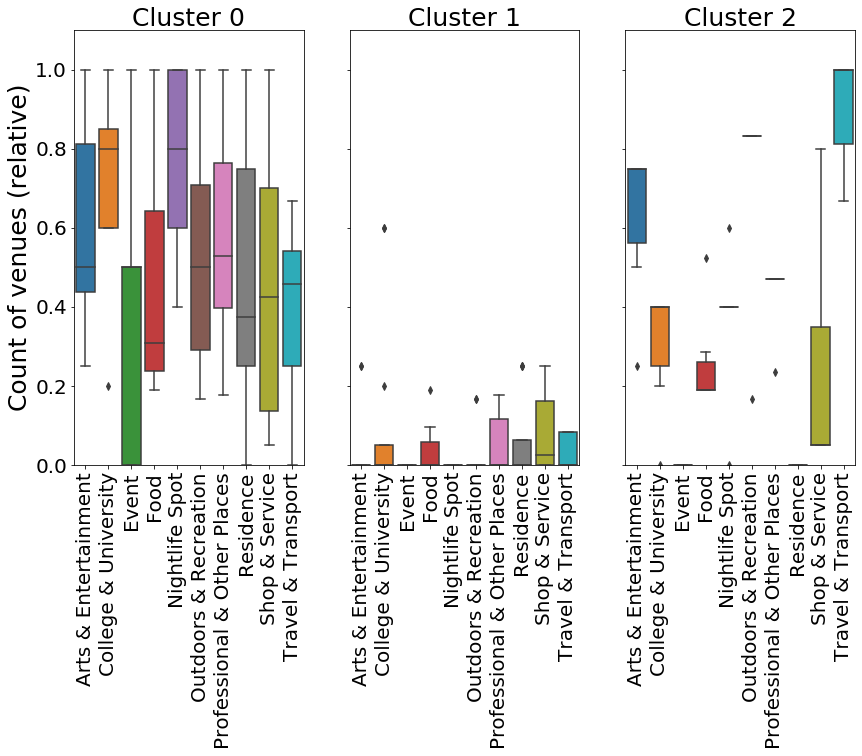

In [68]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

fig2 = plt.gcf()

plt.show()

In [69]:
fig2.savefig("4ClusterBoxPlot.png")

Now, we can examine each cluster and observe the number of venues in each categories that distinguish each cluster. We can then assign a name to each cluster.

#### Cluster 1

In [70]:
df_venues.loc[df_venues['Cluster Label'] == 0]

,Pin Code,Location,Latitude,Longitude,Cluster Label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
3,302004,"Arjun Lal sethi nagar,Janta Colony,Jawahar Nag...",26.887956,75.831860,0,2,5,6,5,6,6,3,2,8
4,302005,"A.G.office,High Court,Legislative Assembly,N.C...",26.899511,75.791935,0,4,1,21,4,3,9,3,9,8
5,302006,"Ajmer Road,Industrial Estate,Jaipur R.s.,Khati...",26.914695,75.777270,0,2,3,4,3,1,9,1,8,5
9,302015,"Bajaj Nagar,Bapu Nagar,Barkat Nagar,Gandhi Nag...",26.890574,75.797725,0,3,3,12,4,1,12,1,3,3
10,302016,"Bani Park,Collectorate,Dwarikapuri,Shastri Nag...",26.939149,75.793650,0,1,5,5,5,3,17,1,20,6
12,302018,"Amer Clark hotel,Durgapura",26.855660,75.803751,0,4,4,18,3,4,3,4,14,0
13,302019,Shyam Nagar,26.887180,75.761123,0,1,4,7,5,2,7,2,14,6
15,302021,Vaishali Nagar,26.907973,75.734260,0,2,4,5,2,5,16,0,1,3


#### Cluster 2

In [72]:
df_venues.loc[df_venues['Cluster Label'] == 1]

,Pin Code,Location,Latitude,Longitude,Cluster Label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
2,302003,"Haldiyon Ka rasta,Jaipur City,Krishi Upaj mand...",26.910635,75.849662,1,1,0,0,0,1,3,0,3,1
7,302012,"Bindayaka,Dhankya,Jhotwara,Jhotwara Industrial...",26.960270,75.665821,1,0,0,0,0,0,0,0,0,0
8,302013,"Akhepura,Murlipura,Neendar,Road No-5 vkia,Vish...",27.044835,75.805821,1,0,0,2,0,0,0,0,0,0
11,302017,"Malviya Industrial area,Malviya Nagar,Mrec Jai...",26.837535,75.843069,1,0,0,0,0,1,2,1,4,1
14,302020,"Mansarovar,S.F.s.mansarovar",26.850430,75.754221,1,0,0,1,0,0,2,0,1,0
16,302022,Sitapura Industrial area,26.734907,75.858370,1,0,0,0,0,0,0,0,0,0
18,302024,Heerapura,26.882650,75.725978,1,0,3,2,0,0,2,0,4,1
20,302026,"Bhambhoria,Bhankrota,Jaisinghpura Bas,Mukandpu...",26.843485,75.644101,1,0,0,0,0,0,0,0,0,0
21,302027,"Crpf Campus lalwas,Indergarh,Jaisingh Pura kh...",26.978205,75.975758,1,0,0,0,0,0,0,0,0,0
22,302028,"Amer,Basna,Bhanpur Kalan,Bilod,Dhand,Khora Mee...",26.991700,75.885633,1,1,1,0,0,0,0,1,1,1


#### Cluster 3

In [74]:
df_venues.loc[df_venues['Cluster Label'] == 2]

,Pin Code,Location,Latitude,Longitude,Cluster Label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,302001,"Ashoknagar,Bhura Tiba,C.P.m.g,Chandpole Bazar,...",26.930038,75.805092,2,2,1,6,3,5,4,0,16,8
1,302002,"Amer Road,Govind Nagar,Kishanpole Bazar,Shivaj...",26.942591,75.838600,2,1,0,11,0,1,8,0,9,9
6,302011,Airport Sanganer,26.925730,75.806590,2,3,2,4,2,5,8,0,1,12
17,302023,"Amba Bari,Dehar Ka balaji,Vidhyadhar Nagar",26.925730,75.806590,2,3,2,4,2,5,8,0,1,12
19,302025,Jagatpura,26.925730,75.806590,2,3,2,4,2,5,8,0,1,12
24,302032,Harmada,26.925730,75.806590,2,3,2,4,2,5,8,0,1,12


# 5. Results

<p style='text-align: justify;'>After visualizing and seeing the data for each cluster, we observed that Cluster 0 is the most developed cluster and could be labeled <strong>'Most Developed'</strong>. Cluster 1 appears to be least developed among all the clusters and could be labeled <strong>'Under Developed'</strong>. Further, Cluster 2 seems to be moderately developed area where some categories like 'Shop & Service' and 'Travel & Transport' are well developed. Thus it could be labeled as <strong>'Moderately Developed'</strong>.</p>

<p style='text-align: justify;'>Since our goal is to find the under developed area, we could target Neighborhoods under Cluster 1. These neighborhoods would be best to start development activities considering future demand in mind.</p>

<p style='text-align: justify;'>Although I have arrived at my findings using only venues and categories data, further analysis could be done in this field, including other important parameters like population of the areas, income of people and other relevant factors in our date, to arrive at more refined clusters.</p>